# Siamese Network with CNN

In this little experiment, we are going to create an "Y model" based on MNIST model. The "Y model" has two inputs and one outputs. The Y-Network uses the same input twice, both on the left and right CNN branches. The network combines the results using concatenate layer. The merge operation concatenate is similar to stacking two tensors of the same shape along the concatenation axis to form one tensor.

### import libraries 

In [16]:
import numpy as np
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.layers.merge import concatenate
from keras.datasets import mnist
import matplotlib.pyplot as plt

### load data

In [18]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()

### compute the number of labels

In [19]:
num_labels = len(np.unique(y_train))

### mnist example

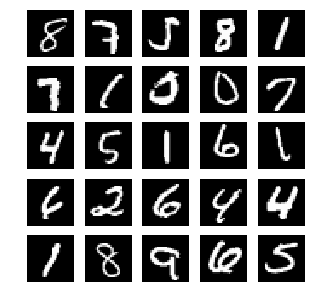

In [20]:
indexes = np.random.randint(0,x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5,5,i+1)
    image = images[i]
    plt.imshow(image,cmap='gray')
    plt.axis('off')

plt.show()
plt.close('all')

### reshape and normalize the data

In [23]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size,image_size,1])
x_test = np.reshape(x_test,[-1,image_size,image_size,1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### network parameters

In [25]:
input_shape = (image_size,image_size,1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

### left branch of Y network

In [26]:
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters

### 3 layers of Conv2D-Dropout-MaxPooling2D number of filters doubles after each layer (32-64-128)

In [27]:
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

### right branch of Y network

In [28]:
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters

### 3 layers of Conv2D-Dropout-MaxPooling2D number of filters doubles after each layer (32-64-128)

In [29]:
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

### merge left and right branches outputs

In [30]:
y = concatenate([x,y])

### feature maps to vector before connecting to dense layer

In [31]:
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels,activation='softmax')(y)

### build the model in functional API

In [32]:
model = Model([left_inputs,right_inputs],outputs)

### verify the model

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 32)   320         input_4[0][0]                    
____________________________________________________________________________________________

### compile and train  the model

In [34]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

model.fit([x_train,x_train],
          y_train, validation_data=([x_test,x_test],y_test),
          epochs=20,
          batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 123s 2ms/step - loss: 0.1910 - accuracy: 0.9406 - val_loss: 0.1945 - val_accuracy: 0.9836
Epoch 2/20
60000/60000 [==============================] - 131s 2ms/step - loss: 0.0719 - accuracy: 0.9784 - val_loss: 0.1506 - val_accuracy: 0.9888
Epoch 3/20
60000/60000 [==============================] - 138s 2ms/step - loss: 0.0524 - accuracy: 0.9836 - val_loss: 0.1057 - val_accuracy: 0.9907
Epoch 4/20
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0813 - val_accuracy: 0.9923
Epoch 5/20
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.0728 - val_accuracy: 0.9918
Epoch 6/20
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0351 - accuracy: 0.9893 - val_loss: 0.0828 - val_accuracy: 0.9932
Epoch 7/20
60000/60000 [==============================] - 131s

### model accuracy on test dataset

In [35]:
score = model.evaluate([x_test,x_test],y_test,batch_size=batch_size)
print("\nTEST ACCURACY: %.1f%%" % (100*score[1]))

10000/10000 [==============================] - 5s 527us/step

TEST ACCURACY: 99.5%


### Last comments

As we can see, over the course of the 20 epochs, the accuracy of the Y-Network is 99.5%. This is a slight improvement over the 3-stack CNN which achieved a score of 99.3% (https://github.com/AndryRafam/DEEP-LEARNING/blob/master/Artificial_Neural_Network/CNN.ipynb). However, this was at the cost of both higher complexity and more than double the number of parameters.